In [1]:
%load_ext autoreload
%autoreload 2

In [212]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from solardatatools import DataHandler
from spcqe.functions import make_basis_matrix

from utils.load_redshift_data import load_redshift_data
import utils.dilatation as dilatation

## Sample basis

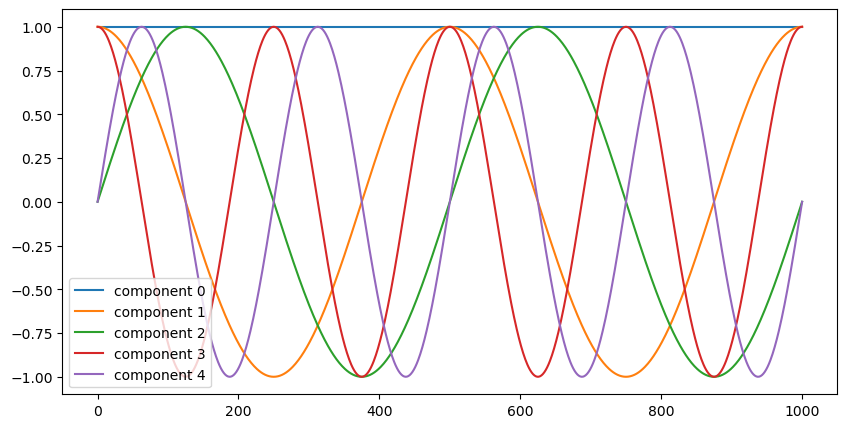

In [214]:
basis = make_basis_matrix(num_harmonics=2,
                           length=1000+1,
                           periods=500,
                           standing_wave=False,
                           trend=False,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(10, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

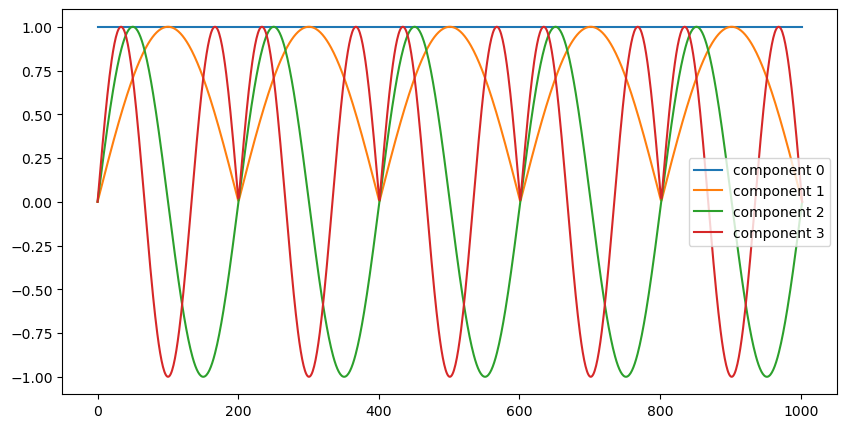

In [215]:
basis = make_basis_matrix(num_harmonics=3,
                           length=1002+1,
                           periods=200.4,
                           standing_wave=True,
                           trend=False,
                           max_cross_k=None,
                           custom_basis=None)
plt.figure(figsize=(10, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

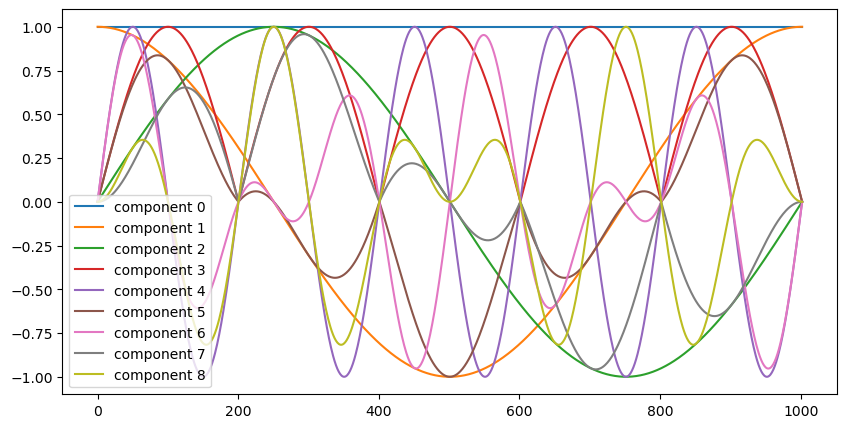

In [216]:
basis = make_basis_matrix(num_harmonics=[2, 1],
                          length=1002+1,
                          periods=[200.4, 1002],
                          standing_wave=[True, False],
                          trend=False,
                          max_cross_k=None,
                          custom_basis=None)
plt.figure(figsize=(10, 5))
for i in range(basis.shape[1]):
    plt.plot(basis[:, i], label=f'component {i}')
plt.legend()
plt.show()

## With PV data

In [5]:
query = {
'siteid': "TADBC1078041",
'api_key': os.environ.get('REDSHIFT_API_KEY'),
'sensor': 0
}
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()

/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.12/site-packages/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.12/site-packages/solardatatools/time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.12/site-packages/solardatatools/time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

total time: 53.58 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              15.14s
Cleaning                   0.78s
Filtering/Summarizing      37.66s
    Data quality           0.45s
    Clear day detect       0.95s
    Clipping detect        25.84s
    Capacity change detect 10.42s



In [32]:
# For now, dilatation can not handle NaNs. We us the filled data matrix, dilate, then add the NaNs again. It will change it soon.
signal_series = pd.Series(
    data= dh.filled_data_matrix.ravel(order='F') / dh.capacity_estimate,
    index = dh.data_frame.index
    )
sunrises = dh.daytime_analysis.sunrise_estimates
sunsets = dh.daytime_analysis.sunset_estimates

In [39]:
nvals_ori = dh.raw_data_matrix.shape[0]
nvals_dil = 101
ndays = 700

In [34]:
# Dilatation
# Indexes have 1 more value than the signals (the right boundary of the last bin)
idx_ori = dilatation.build_original_idx(signal_series, nvals_ori)
idx_dil = dilatation.build_dilated_idx(sunrises, sunsets, idx_ori, nvals_dil)
signal_ori = signal_series.to_numpy()
signal_dil = dilatation.dilate_signal(idx_dil, idx_ori, signal_ori)

In [35]:
# Add NaNs again
_sig = signal_ori.reshape((nvals_ori, dh.raw_data_matrix.shape[1]), order='F')
nan_mask_ori = np.tile(dh.daily_flags.no_errors, (nvals_ori, 1))
_sig[~nan_mask_ori] = np.nan
signal_ori = _sig.ravel(order='F')

_sig = signal_dil[1:].reshape((nvals_dil, dh.raw_data_matrix.shape[1]), order='F')
nan_mask_dil = np.tile(dh.daily_flags.no_errors, (nvals_dil, 1))
_sig[~nan_mask_dil] = np.nan
signal_dil[1:] = _sig.ravel(order='F')

In [51]:
# Crop
idx_ori = idx_ori[0*nvals_ori:ndays*nvals_ori+2] # starts at the first midnight, ends 24h/nvlas_ori after the ndays-th midnight
signal_ori = signal_ori[0*nvals_ori:ndays*nvals_ori+1]
idx_dil = idx_dil[0*nvals_dil:ndays*nvals_dil+2]  # starts at the first midnight, ends at the first sunrise after the ndays-th midnight
signal_dil = signal_dil[0*nvals_dil:ndays*nvals_dil+1]

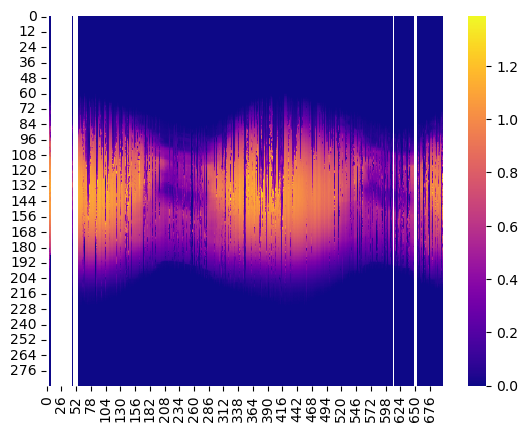

In [55]:
sns.heatmap(signal_ori[:-1].reshape((nvals_ori, ndays), order='F'), cmap='plasma');

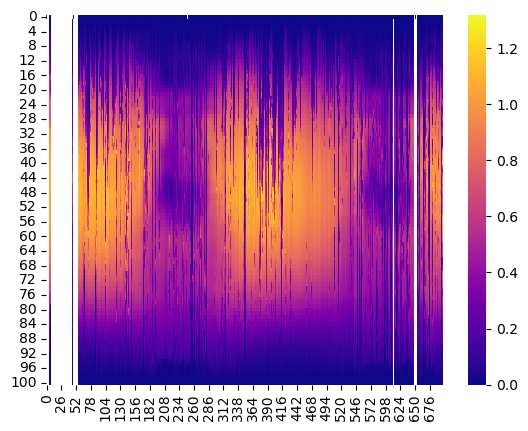

In [56]:
sns.heatmap(signal_dil[:-1].reshape((nvals_dil, ndays), order='F'), cmap='plasma');

In [217]:
regular_basis = make_basis_matrix(
    num_harmonics=[2, 2],
    length=signal_dil.shape[0],
    periods=[nvals_dil, 365.24225*nvals_dil],
    standing_wave=False,
    trend=False,
    max_cross_k=None,
    custom_basis=None
)

In [218]:
standing_wave_basis = make_basis_matrix(
    num_harmonics=[4, 2],
    length=signal_dil.shape[0],
    periods=[nvals_dil, 365.24225*nvals_dil],
    standing_wave=[True, False],
    trend=False,
    max_cross_k=None,
    custom_basis=None
)

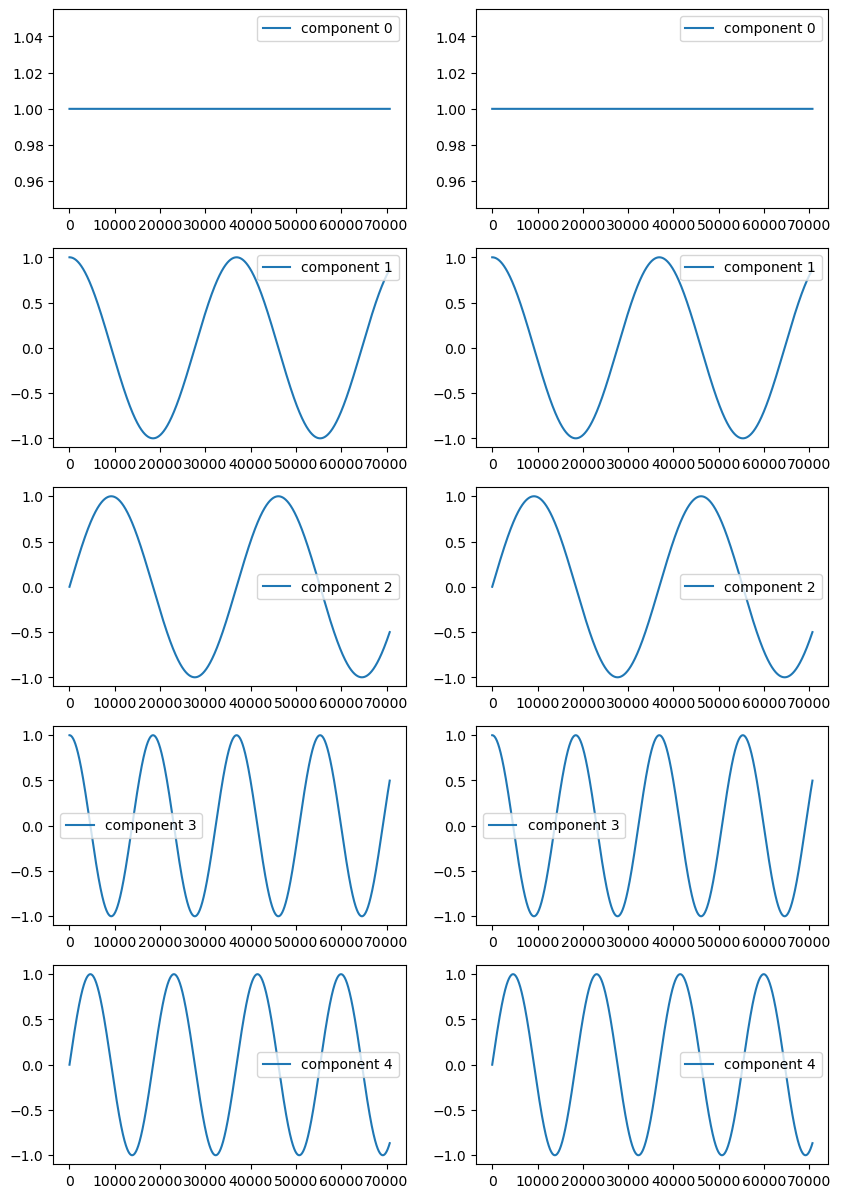

In [219]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    ax[i, 0].plot(regular_basis[:, i], label=f'component {i}')
    ax[i, 1].plot(standing_wave_basis[:, i], label=f'component {i}')
    ax[i, 0].legend()
    ax[i, 1].legend()
plt.show()

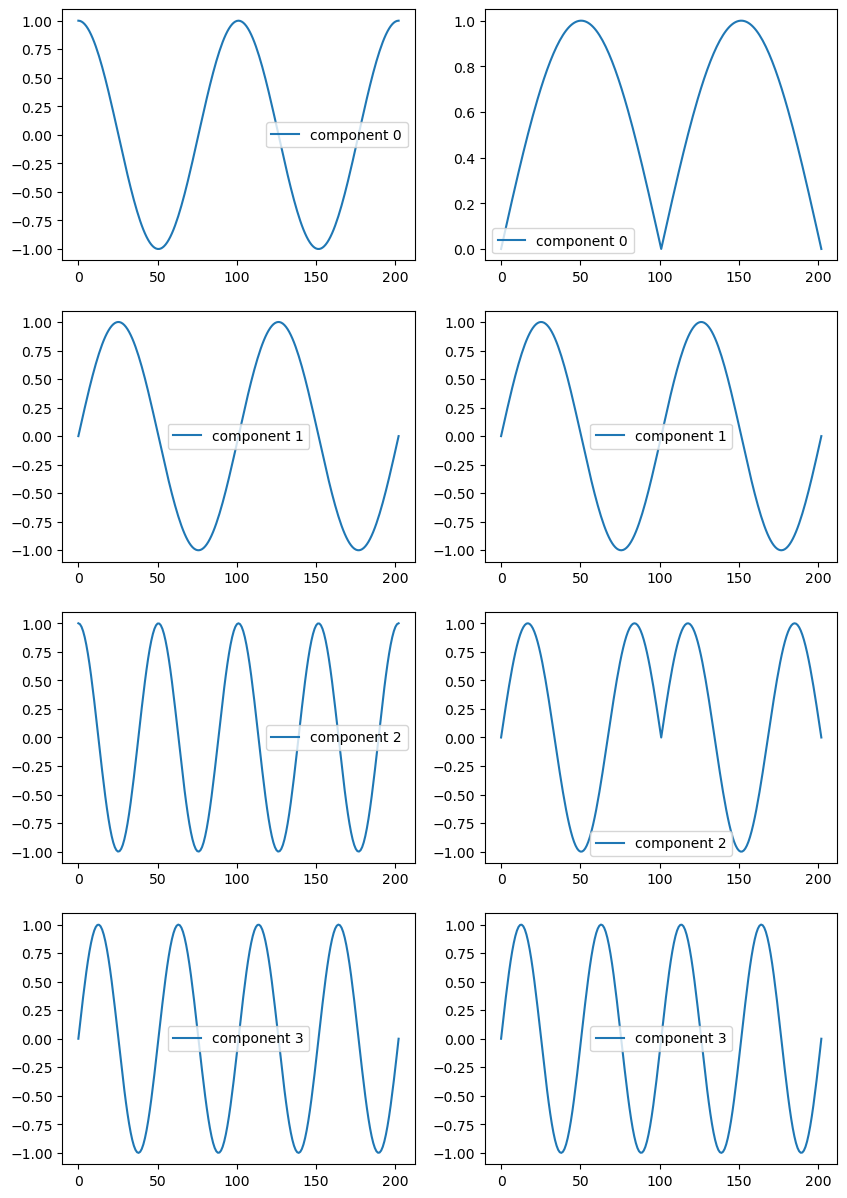

In [220]:
fig, ax = plt.subplots(4, 2, figsize=(10, 15))
for i in range(4):
    ax[i, 0].plot(regular_basis[0:nvals_dil*2 + 1, i+5], label=f'component {i}')
    ax[i, 1].plot(standing_wave_basis[0:nvals_dil*2 + 1, i+5], label=f'component {i}')
    ax[i, 0].legend()
    ax[i, 1].legend()
plt.show()